In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn


#data = pd.read_csv('AMZN.csv') #OG test data
data = pd.read_csv('COKE_STOCK_DATA(polished).csv')
print(data)


           Date  Close/Last    Volume   Open   High    Low
0     3/12/2025       69.94  18923300  70.37  70.73  69.74
1     3/11/2025       71.04  28076440  71.88  72.04  70.61
2     3/10/2025       71.45  25251190  71.96  73.22  71.32
3      3/7/2025       71.43  28393260  69.65  71.82  69.65
4      3/6/2025       70.46  21694030  70.41  70.53  69.45
...         ...         ...       ...    ...    ...    ...
2510  3/19/2015       40.02  16013260  40.48  40.52  39.96
2511  3/18/2015       40.60  26203370  40.48  40.79  39.80
2512  3/17/2015       40.51  21661600  40.67  40.73  40.32
2513  3/16/2015       40.29  15223290  40.00  40.35  39.99
2514  3/13/2015       39.91  17368250  40.44  40.57  39.61

[2515 rows x 6 columns]


In [2]:
#data = data[['Date','Close']] #OG
data = data[['Date','Close/Last']] 


In [3]:
print(torch.cuda.is_available())
#I do not have a CPU so this would swtich it to using the GPU
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'


False


In [4]:
from copy import deepcopy as dc

def play_it_back(df,n_steps): #take in dataframe and sets predictions in the past
    df = dc(df) #copy
    df.set_index('Date', inplace=True)  #sets our date to be our index which sounds incredibly useful
    
    for i in range(1, n_steps+1): #how many frames into the past we're looking
        df[f'Close(t-{i})'] = df['Close/Last'].shift(i) # shift lets you traverse the dates
    df.dropna(inplace=True) #this takes out anything that doesn't fit nicely

    return df
lookback = 7
shifted_df = play_it_back(data,lookback)
shifted_df
# prepare_dataframe_for_lstm = play_it_back

,Close/Last,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
3/3/2025,72.32,70.19,70.08,70.46,71.43,71.45,71.04,69.94
2/28/2025,71.21,72.32,70.19,70.08,70.46,71.43,71.45,71.04
2/27/2025,70.87,71.21,72.32,70.19,70.08,70.46,71.43,71.45
2/26/2025,70.80,70.87,71.21,72.32,70.19,70.08,70.46,71.43
2/25/2025,71.49,70.80,70.87,71.21,72.32,70.19,70.08,70.46
...,...,...,...,...,...,...,...,...
3/19/2015,40.02,40.65,40.62,40.47,40.45,40.35,40.08,40.51
3/18/2015,40.60,40.02,40.65,40.62,40.47,40.45,40.35,40.08
3/17/2015,40.51,40.60,40.02,40.65,40.62,40.47,40.45,40.35


In [5]:
shifted_df_as_np= shifted_df.to_numpy()

from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1,1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[ 0.96107193,  0.84090268,  0.83469676, ...,  0.91198872,
         0.88885755,  0.82679831],
       [ 0.89844852,  0.96107193,  0.84090268, ...,  0.91086037,
         0.91198872,  0.88885755],
       [ 0.87926657,  0.89844852,  0.96107193, ...,  0.8561354 ,
         0.91086037,  0.91198872],
       ...,
       [-0.83356841, -0.82849083, -0.86121298, ..., -0.83582511,
        -0.83695346, -0.8425952 ],
       [-0.84598025, -0.83356841, -0.82849083, ..., -0.82736248,
        -0.83582511, -0.83695346],
       [-0.8674189 , -0.84598025, -0.83356841, ..., -0.82566996,
        -0.82736248, -0.83582511]])

In [6]:
X = shifted_df_as_np[:,1:]
y = shifted_df_as_np[:,0]
X = dc(np.flip(X,axis=1)) #you flip the data to make the recursion work better
X.shape, y.shape

((2508, 7), (2508,))

In [7]:
split_index = int(len(X) * 0.95) #this leaves the last 5% as training data

#split_index

In [8]:
#splitting our data up
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]
#X_train.shape,X_test.shape,y_train.shape,y_test.shape


In [9]:
#adding an extra dimension becaue pytorch wants an extra dimension at the end
X_train = X_train.reshape((-1,lookback,1))
X_test = X_test.reshape((-1,lookback,1))

y_train = y_train.reshape((-1,1))
y_test = y_test.reshape((-1,1))
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((2382, 7, 1), (126, 7, 1), (2382, 1), (126, 1))

In [10]:
#data manipulation is done time to get it into meat and potatos
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([2382, 7, 1]),
 torch.Size([126, 7, 1]),
 torch.Size([2382, 1]),
 torch.Size([126, 1]))

In [11]:
from torch.utils.data import Dataset 

class TimeSeriesDataset(Dataset): #noteable limitation for fellows devs, ACCESS IS DATE BASED
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [12]:
#Batch action starts here
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size,shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size,shuffle=False)


In [13]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device) #cpu or gpu stuff
    print(x_batch.shape,y_batch.shape)
    break

#PREPROCESSING COMPLETE 

torch.Size([16, 7, 1]) torch.Size([16, 1])


In [14]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first=True) 

        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        #h0 and c0 are defaults 

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :]) #this is where we get our acutal data
        return out

model = LSTM(1, 4, 1)
model.to(device)
model
#definition of the network complete

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [15]:
#COMENCE TRAINING
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [16]:

def validate_one_epoch():
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            

            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()
    

In [17]:
#control panel

learning_rate = 0.1
num_epochs = 10
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    train_one_epoch()
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.032

Val Loss: 0.001
***************************************************

Epoch: 2
Batch 100, Loss: 0.002

Val Loss: 0.002
***************************************************

Epoch: 3
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 4
Batch 100, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 5
Batch 100, Loss: 0.002

Val Loss: 0.002
***************************************************

Epoch: 6
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 7
Batch 100, Loss: 0.002

Val Loss: 0.000
***************************************************

Epoch: 8
Batch 100, Loss: 0.002

Val Loss: 0.002
***************************************************

Epoch: 9
Batch 100, Loss: 0.002

Val Loss: 0.001
***************************************************

Epoch: 10
Batch 100, Loss: 0.002

Val Loss: 0.001
********************************

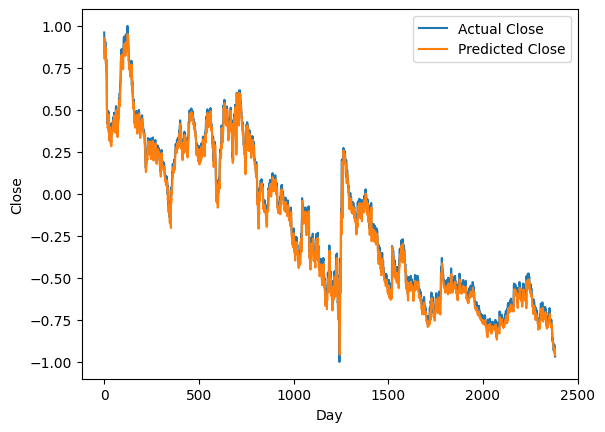

In [18]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()


In [19]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([69.59964488, 71.71321694, 70.43302504, ..., 38.94693038,
       38.59844427, 38.24491447])

In [20]:
#train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

C:\Users\horus\AppData\Local\Temp\ipykernel_4348\3853723676.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_train.flatten()


array([72.31999958, 71.21000014, 70.86999978, ..., 38.50000032,
       38.09999964, 38.1299998 ])

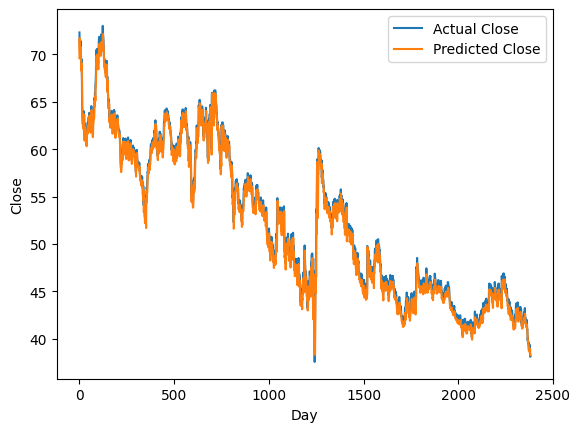

In [21]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [22]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([38.0929391 , 38.17488593, 38.17155798, 38.46893944, 38.42119972,
       38.71161467, 38.71287401, 38.61870462, 38.87683528, 39.07620806,
       39.04866742, 38.7494371 , 38.27312493, 38.21089647, 38.84593816,
       39.80839317, 40.27546948, 40.74259862, 40.89760612, 40.85276541,
       40.72932063, 40.79846593, 40.98214135, 41.17841121, 41.29081883,
       41.42202884, 41.60122473, 41.44555586, 41.17704517, 40.79751509,
       40.35876862, 40.23163667, 40.18494816, 40.16910078, 40.10328976,
       40.33865617, 40.46596561, 40.69404646, 40.8935925 , 40.85409026,
       40.99010942, 40.79694247, 40.75220636, 40.421164  , 40.13760885,
       39.7733229 , 39.60279976, 39.78868958, 39.40304664, 39.2572581 ,
       39.22190681, 39.0700635 , 39.09427619, 39.47078576, 39.6366223 ,
       39.784396  , 39.95117916, 40.06959399, 40.05408468, 40.20052297,
       40.01941694, 39.82780621, 39.48546149, 39.55827283, 39.69639124,
       39.89091156, 39.8771518 , 39.83583872, 39.78401778, 40.07

In [23]:
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

C:\Users\horus\AppData\Local\Temp\ipykernel_4348\1312012603.py:2: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  dummies[:, 0] = y_test.flatten()


array([38.41999955, 38.29999998, 38.89999993, 38.51999971, 39.15999952,
       38.89999993, 38.75000021, 39.32000001, 39.45000033, 39.27000045,
       38.72999975, 37.98999977, 38.37999969, 39.53000004, 40.55000007,
       40.77999951, 41.29999975, 41.35000036, 41.25000019, 41.10000047,
       41.25999989, 41.47999963, 41.67999996, 41.77000043, 41.92000016,
       42.12000049, 41.85000015, 41.53999994, 41.08000001, 40.55999977,
       40.58999993, 40.55000007, 40.54000037, 40.4400002 , 40.83999982,
       40.90000013, 41.18999988, 41.38000052, 41.25000019, 41.47999963,
       41.12999957, 41.17000048, 40.65999994, 40.38999959, 39.91999996,
       39.85999965, 40.24999956, 39.42000017, 39.49000019, 39.49999989,
       39.22999954, 39.39999972, 39.99999967, 40.02000013, 40.19000031,
       40.37999989, 40.48000006, 40.40000034, 40.65000024, 40.27000002,
       40.08000044, 39.59000035, 39.95999982, 40.09999984, 40.33000033,
       40.20000001, 40.16000015, 40.09999984, 40.58999993, 40.86

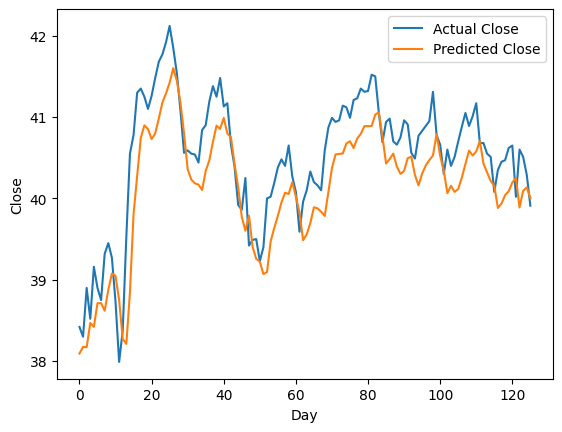

In [24]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()